# Clustering
## Transformation

Transforming features that are heavily skewed can help clustering algorithms (like k-means) treat them more fairly. So we'll do that first.

**Speechiness and Instrumentalness**: These features are heavily skewed towards low values. Since clustering algorithms like k-means assume roughly spherical clusters (normally distributed features), applying a logarithmic or square root transformation can help normalize the distribution.

**Liveness** is also skewed towards lower values, so we'll do a log transformation here to spread out the lower values more evenly.

In [1]:
import pandas as pd
import numpy as np

# Load clustering data
df = pd.read_csv('clustering_data.csv')

# Handle negative or NaN values before log transformation
for col in ['speechiness', 'instrumentalness', 'liveness']:
    df[col] = df[col].clip(lower=0).fillna(0)  # Replace NaN and negative values with 0
    df[f'{col}_log'] = np.log1p(df[col])  # log(1 + x)


# Features to use for clustering
clustering_features = ['danceability', 'energy', 'valence', 'tempo', 
                       'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']

# Select the features for clustering and drop NaN rows
X = df[clustering_features].dropna()

print("Data shape:", X.shape)
print("Features used for clustering:", clustering_features)


Data shape: (89740, 8)
Features used for clustering: ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']


## Number of clusters

Before applying k-means, it’s important to decide on the number of clusters (k). We'll use the Elbow Method to help determine an appropriate value of k.

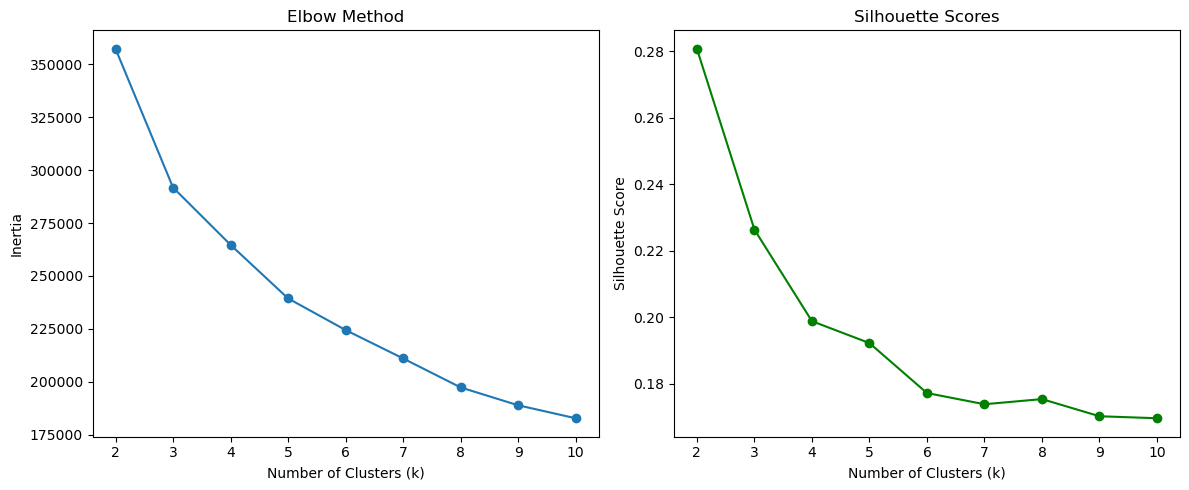

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Test different numbers of clusters
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot the Elbow Method (inertia vs. k)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, '-o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()


## K-Means Clustering

C:\Users\Rohan\AppData\Local\Temp\ipykernel_15500\2087923781.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\Rohan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


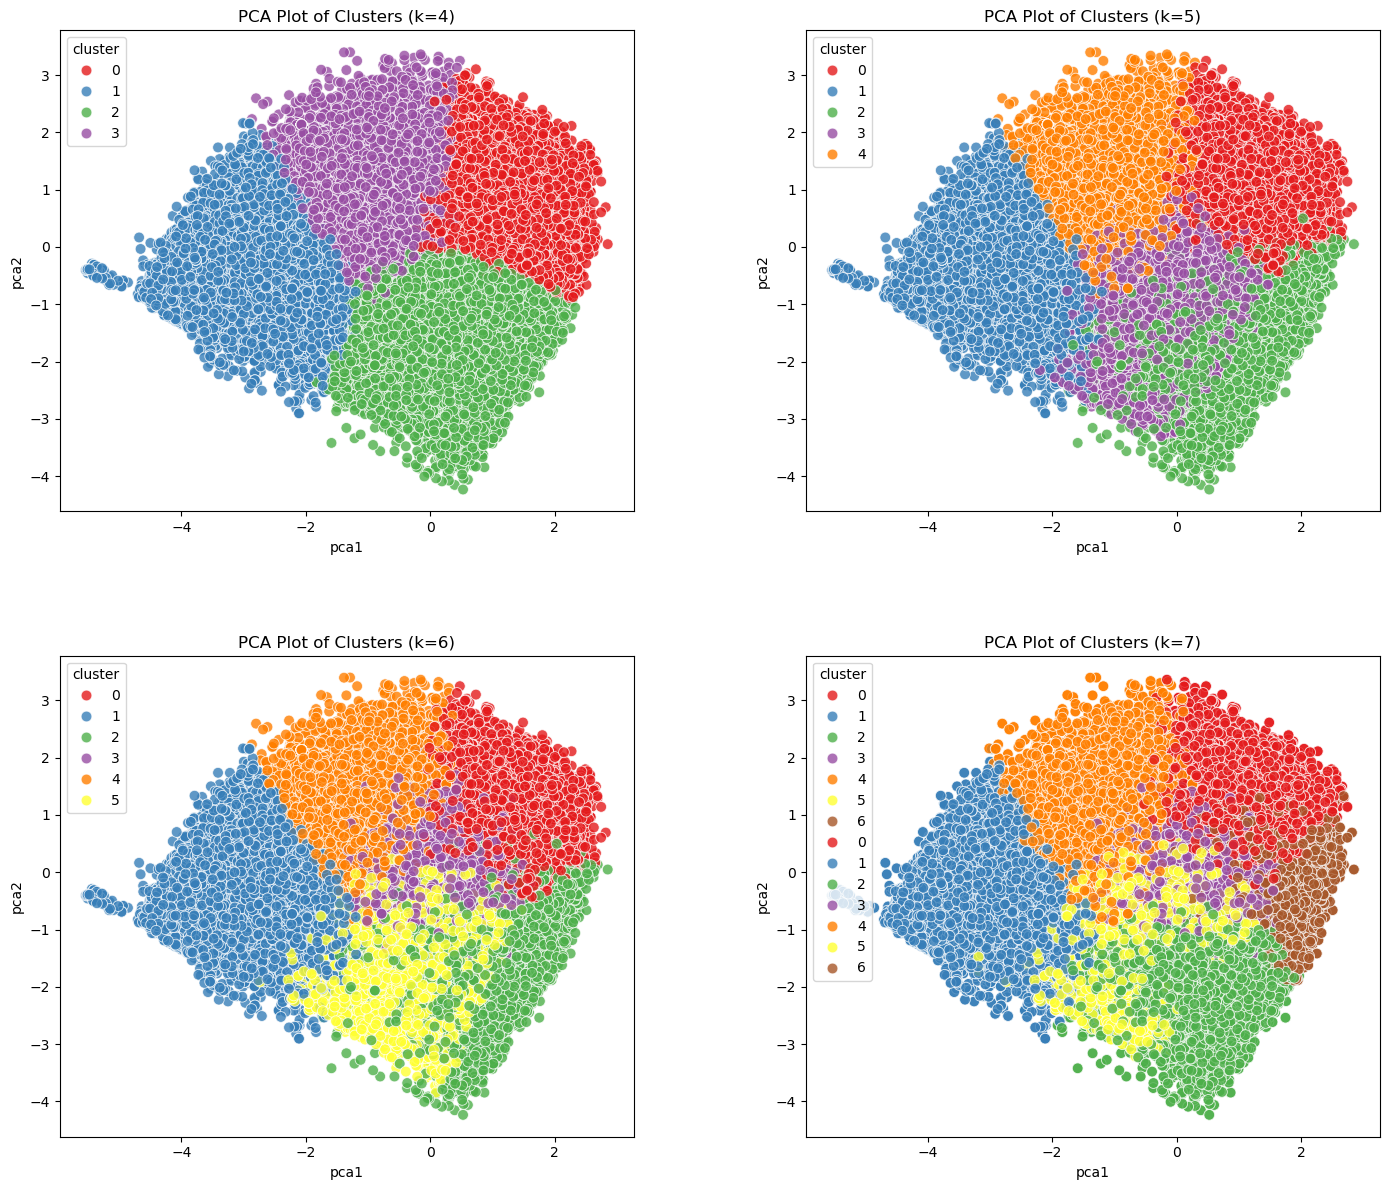

In [3]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce the dimensionality to 2D for visualization
plt.figure(figsize=(14, 12))
pca = PCA(n_components=2)
for i, k in enumerate([4, 5, 6, 7], start=1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)
    pca_components = pca.fit_transform(X)
    df['pca1'], df['pca2'] = pca_components[:, 0], pca_components[:, 1]
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1', s=60, alpha=0.8)
    plt.title(f'PCA Plot of Clusters (k={k})')

#Plots showing how different k-means make clusters
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1', s=60, alpha=0.8)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()



### k=4:

Clusters are well-separated and distinct.
Simplified structure, likely representing broad groupings in the data.
This is a good choice if you want fewer, more interpretable clusters.

### k=5:

Clusters remain distinct but with an additional layer of granularity.
One of the clusters from k=4 appears to split into two smaller clusters, adding detail.
This could better capture nuanced differences between the data points while maintaining clarity.
### k=6:

The separation between clusters starts to blur, particularly in some areas where clusters overlap.
Adding more clusters provides diminishing interpretability.
Suitable if very fine-grained distinctions are needed.

### k=7:

Clusters are more fragmented, with noticeable overlap.
Less distinct structure and potentially overfitting.
This might not add much value unless your dataset inherently supports this level of granularity.

It seems that with the shilouette scores and the looks of the clustering k=5 is the best choice.
It strikes the best balance between interpretability and granularity.
Provides more nuanced clusters than k=4 without the overlap or fragmentation seen in k=6 and k=7.
Captures distinct patterns in the data, as seen from the clear separation in the PCA visualization.

In [4]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)  # Assign cluster labels to the DataFrame

# Get the mean values of features for each cluster
cluster_means = df.groupby('cluster')[clustering_features].mean()
print(cluster_means)


         danceability    energy   valence     tempo  acousticness  \
cluster                                                             
0            0.842472  0.426047  0.979047 -0.096716     -0.440028   
1           -1.235944 -1.610956 -1.081473 -0.616607      1.475562   
2           -0.587671  0.666842 -0.094293  1.361056     -0.605582   
3           -0.190869  0.484126 -0.740384 -0.371167     -0.720333   
4            0.287967 -0.743791  0.175244 -0.246376      1.068323   

         speechiness_log  instrumentalness_log  liveness_log  
cluster                                                       
0               0.171347              0.106454      0.183506  
1               0.022786              0.539414      0.125350  
2               0.187379              0.159433      0.266811  
3               0.114457              0.306520      0.234745  
4               0.197185              0.135208      0.210063  



#### **Cluster 0**
- **High Danceability (`0.842`):** This cluster likely represents very danceable tracks, possibly dance, pop, or electronic music.
- **Moderate Energy (`0.426`):** These tracks are somewhat energetic but not extremely so.
- **Very High Valence (`0.979`):** Tracks are extremely positive or happy in mood.
- **Low Tempo (`-0.096`):** Slightly below the average tempo.
- **Low Acousticness (`-0.440`):** These are unlikely to be acoustic; more likely electronically produced.
- **Low Speechiness (`0.171`):** Mostly musical, with minimal spoken words.
- **Low Instrumentalness (`0.106`):** These tracks likely have vocals.
- **Moderate Liveness (`0.183`):** These tracks have a moderate live feel, but not overly live.

**Likely Genre/Type:** Danceable, upbeat pop or electronic tracks.


#### **Cluster 1**
- **Low Danceability (`-1.236`):** These tracks are not very danceable.
- **Very Low Energy (`-1.611`):** Tracks are low in intensity and more relaxed.
- **Low Valence (`-1.081`):** Tracks are more melancholic or somber.
- **Low Tempo (`-0.617`):** Slow-paced tracks.
- **High Acousticness (`1.476`):** Likely acoustic tracks with minimal electronic influence.
- **Low Speechiness (`0.023`):** Tracks are primarily instrumental or musical.
- **Moderate Instrumentalness (`0.539`):** Likely includes instrumental music or tracks with minimal vocals.
- **Low Liveness (`0.125`):** Minimal live performance elements.

**Likely Genre/Type:** Acoustic, calm, and melancholic music (e.g., classical, folk, or acoustic ballads).

#### **Cluster 2**
- **Moderate Danceability (`-0.588`):** Danceability is below average but not extremely low.
- **High Energy (`0.667`):** Tracks are energetic.
- **Neutral Valence (`-0.094`):** Tracks have a balanced mood, neither overly positive nor negative.
- **High Tempo (`1.361`):** Fast-paced tracks.
- **Low Acousticness (`-0.606`):** Likely electronically produced music.
- **Moderate Speechiness (`0.187`):** Contains some spoken elements, possibly hip-hop or rap.
- **Low Instrumentalness (`0.159`):** Tracks likely feature vocals.
- **High Liveness (`0.267`):** Some live performance elements are present.

**Likely Genre/Type:** Fast-paced, high-energy tracks such as rap, hip-hop, or fast electronic music.

#### **Cluster 3**
- **Moderate Danceability (`-0.191`):** Tracks are somewhat danceable.
- **Moderate Energy (`0.484`):** Tracks have moderate intensity.
- **Low Valence (`-0.740`):** Tracks are slightly melancholic or darker in mood.
- **Low Tempo (`-0.371`):** Tracks are slower-paced.
- **Low Acousticness (`-0.720`):** Likely electronically produced.
- **Low Speechiness (`0.114`):** Primarily musical, with minimal spoken words.
- **Moderate Instrumentalness (`0.307`):** Likely includes some instrumental music or tracks with minimal vocals.
- **Moderate Liveness (`0.235`):** Tracks have some live elements.

**Likely Genre/Type:** Darker, electronic tracks or alternative music with moderate energy.
#### **Cluster 4**
- **Moderate Danceability (`0.288`):** Tracks are somewhat danceable.
- **Low Energy (`-0.744`):** Tracks are less intense or mellow.
- **Moderate Valence (`0.175`):** Tracks are slightly positive in mood.
- **Low Tempo (`-0.246`):** Tracks are slower-paced.
- **High Acousticness (`1.068`):** Tracks are likely acoustic.
- **Moderate Speechiness (`0.197`):** Contains some spoken elements.
- **Low Instrumentalness (`0.135`):** Likely features vocals.
- **Moderate Liveness (`0.210`):** Tracks have some live elements.

**Likely Genre/Type:** Mellow acoustic or singer-songwriter tracks with moderate positivity.


### **Summary of Clusters**
1. **Cluster 0:** Danceable, high-energy pop or electronic tracks.
2. **Cluster 1:** Acoustic, calm, and melancholic tracks.
3. **Cluster 2:** High-energy, fast-paced tracks like rap or hip-hop.
4. **Cluster 3:** Darker, moderate-energy electronic or alternative tracks.
5. **Cluster 4:** Mellow, acoustic tracks with a slight positive mood.



# Clustering Analysis of Music Genres

### Cluster Descriptions

- **Cluster 0**:  
  A vibrant, dance-centric cluster, dominated by **disco**, **party**, and **dancehall**. It also includes genres like **kids** and **afrobeat**, reflecting an upbeat and youthful vibe. With the addition of **ska**, **j-idol**, and **forro**, this cluster is lively and social, making it ideal for celebratory environments.

- **Cluster 1**:  
  This cluster focuses on calm and relaxing genres such as **new-age**, **ambient**, and **classical**. Instrumental elements like **guitar** and **piano** further enhance its soothing nature. The inclusion of **disney** and **sleep** genres makes it child-friendly and suitable for unwinding, studying, or meditative settings.

- **Cluster 2**:  
  Featuring romantic and acoustic genres like **romance**, **opera**, and **show-tunes**, this cluster has an emotional and theatrical appeal. International influences are present with **Cantopop**, **Mandopop**, and **tango**, offering a blend of traditional, melodic, and acoustic sounds.

- **Cluster 3**:  
  This cluster is characterized by high-energy and intense genres such as **minimal-techno**, **grindcore**, and **drum-and-bass**. It leans heavily toward electronic and fast-paced music, appealing to club and rave audiences. Genres like **breakbeat**, **trance**, and **black-metal** amplify its energetic and edgy vibe.

- **Cluster 4**:  
  A heavy and aggressive cluster that includes genres like **heavy-metal**, **metalcore**, and **death-metal**. Influences from **industrial**, **grunge**, and **dub** add a gritty, raw sound, making it perfect for fans of intense rock and metal music.

- **Cluster 5**:  
  This cluster blends cheerful and nostalgic genres such as **comedy**, **salsa**, and **forro**. With **bluegrass**, **honky-tonk**, and **rock-n-roll**, it also appeals to country and retro music lovers. The inclusion of **children** and **pagode** makes it suitable for light-hearted, family-friendly settings.

- **Cluster 6**:  
  A culturally diverse and eclectic cluster featuring genres like **turkish**, **mandopop**, and **world-music**. Emotional genres such as **emo** and rhythmic styles like **hip-hop** broaden its appeal. The inclusion of **french**, **malay**, and **cantopop** further emphasizes its global and multicultural reach.

---

### Summary of Cluster Characteristics

- **Cluster 0**: Upbeat, social, and danceable, with genres like disco, party, and dancehall.
- **Cluster 1**: Calm, relaxing, and instrumental, featuring new-age, ambient, and classical.
- **Cluster 2**: Romantic and acoustic, with genres like opera, romance, and show-tunes.
- **Cluster 3**: High-energy and intense, including techno, drum-and-bass, and grindcore.
- **Cluster 4**: Heavy and aggressive, focusing on metal, grunge, and industrial.
- **Cluster 5**: Cheerful and nostalgic, blending comedy, salsa, and rock-n-roll.
- **Cluster 6**: Diverse and global, with turkish, emo, and world-music genres.


C:\Users\Rohan\AppData\Local\Temp\ipykernel_15500\1732698471.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='energy', palette=palette)


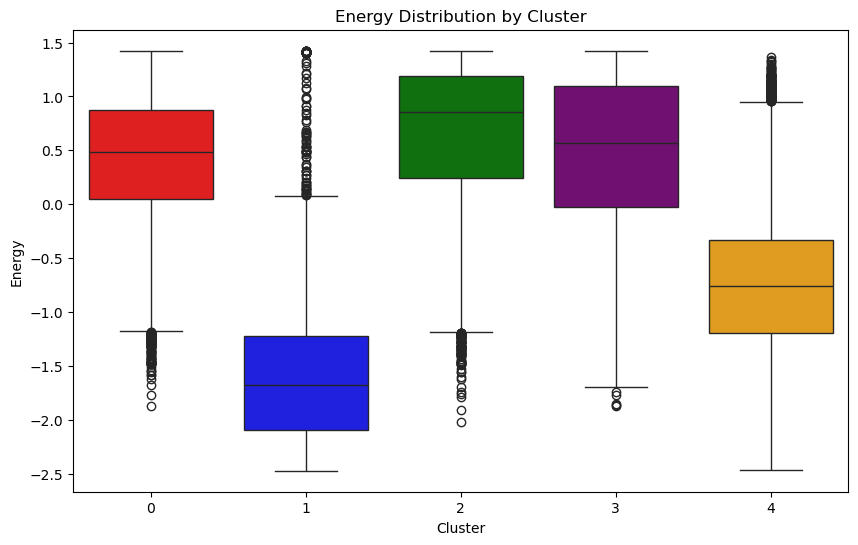

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette for the clusters
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'purple',
    4: 'orange',
    5: 'yellow',
    6: 'brown'
}

# Map the palette to the clusters
palette = [cluster_colors[cluster] for cluster in sorted(df['cluster'].unique())]

# Box plot of energy by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='energy', palette=palette)
plt.title('Energy Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Energy')
plt.show()


### Interpretation of the Energy Distribution by Cluster

- Cluster 0: Moderately high energy, with most tracks above average energy. These are likely vibrant and upbeat tracks.
- Cluster 1: The lowest energy cluster, dominated by calm and relaxing tracks with minimal intensity.
- Cluster 2: The highest energy cluster, with most tracks showing very high energy levels, indicative of fast-paced or intense genres.
- Cluster 3: Moderate energy levels, slightly higher than average. These tracks may have a mix of mellow and upbeat qualities.
- Cluster 4: Lower energy compared to Cluster 0 and Cluster 3, but not as calm as Cluster 1.

C:\Users\Rohan\AppData\Local\Temp\ipykernel_15500\473935751.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='popularity', palette=palette)


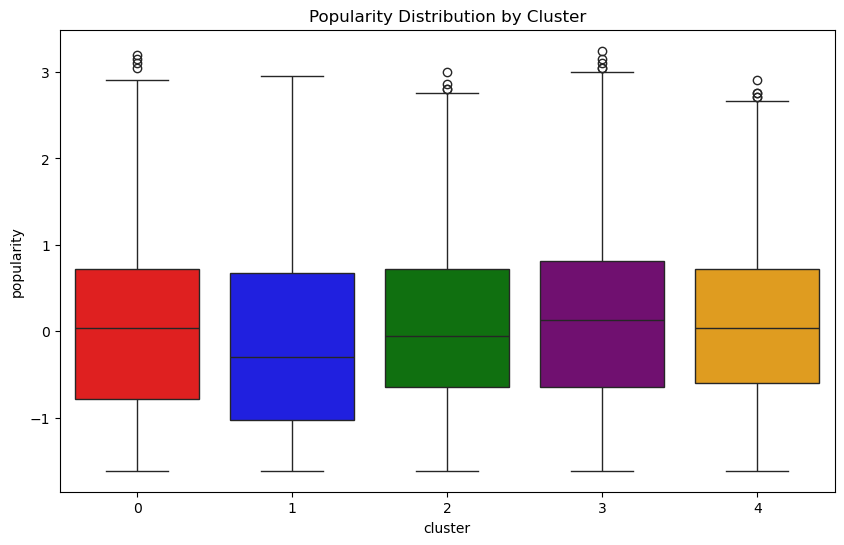

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='popularity', palette=palette)
plt.title('Popularity Distribution by Cluster')
plt.show()

### Interpretation of the Popularity Distribution by Cluster

All Clusters: The popularity distribution appears consistent across clusters, with no cluster having significantly more or less popular tracks.
This indicates that popularity isn’t a defining factor for clustering and is evenly spread.

C:\Users\Rohan\AppData\Local\Temp\ipykernel_15500\1053557521.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='tempo', palette=palette)


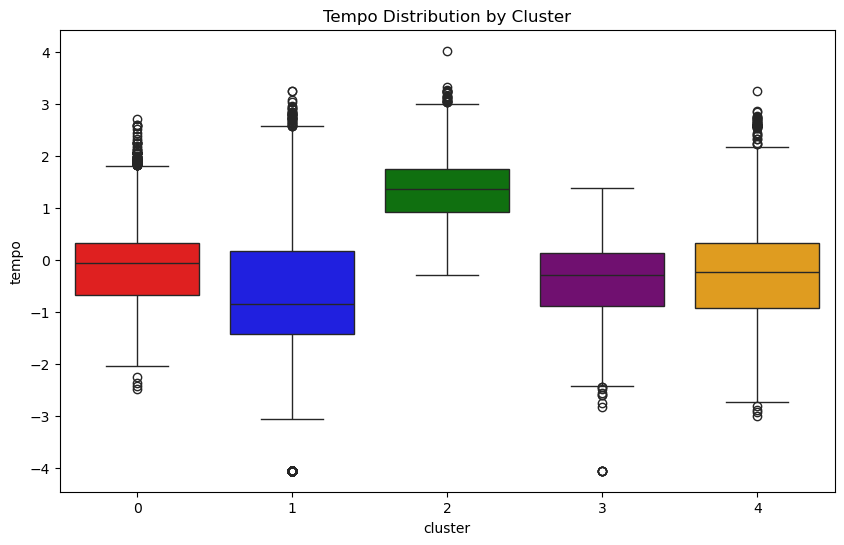

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='tempo', palette=palette)
plt.title('Tempo Distribution by Cluster')
plt.show()

### Interpretation of the Tempo Distribution by Cluster

- Cluster 0: Moderate tempo tracks, hovering around average values.
- Cluster 1: Slower tempo tracks, emphasizing calm and relaxed rhythms.
- Cluster 2: High tempo tracks dominate, corresponding to fast-paced genres like electronic dance or hip-hop.
- Cluster 3: Slightly slower tempo than Cluster 2, but faster than Clusters 0 and 4.
- Cluster 4: Moderately slow tempo, similar to Cluster 1, likely representing mellow acoustic or folk tracks.

## Polar plot analysis:

The polar plot provides a visual representation of the average song attributes across all tracks in the dataset. This approach highlights key features such as danceability, energy, valence, speechiness, acousticness, instrumentalness, and liveness, offering a comprehensive overview of the characteristics that define the dataset's musical profile. By plotting these features on a circular axis, we can easily compare and identify dominant trends or unique attributes in the collection of tracks.

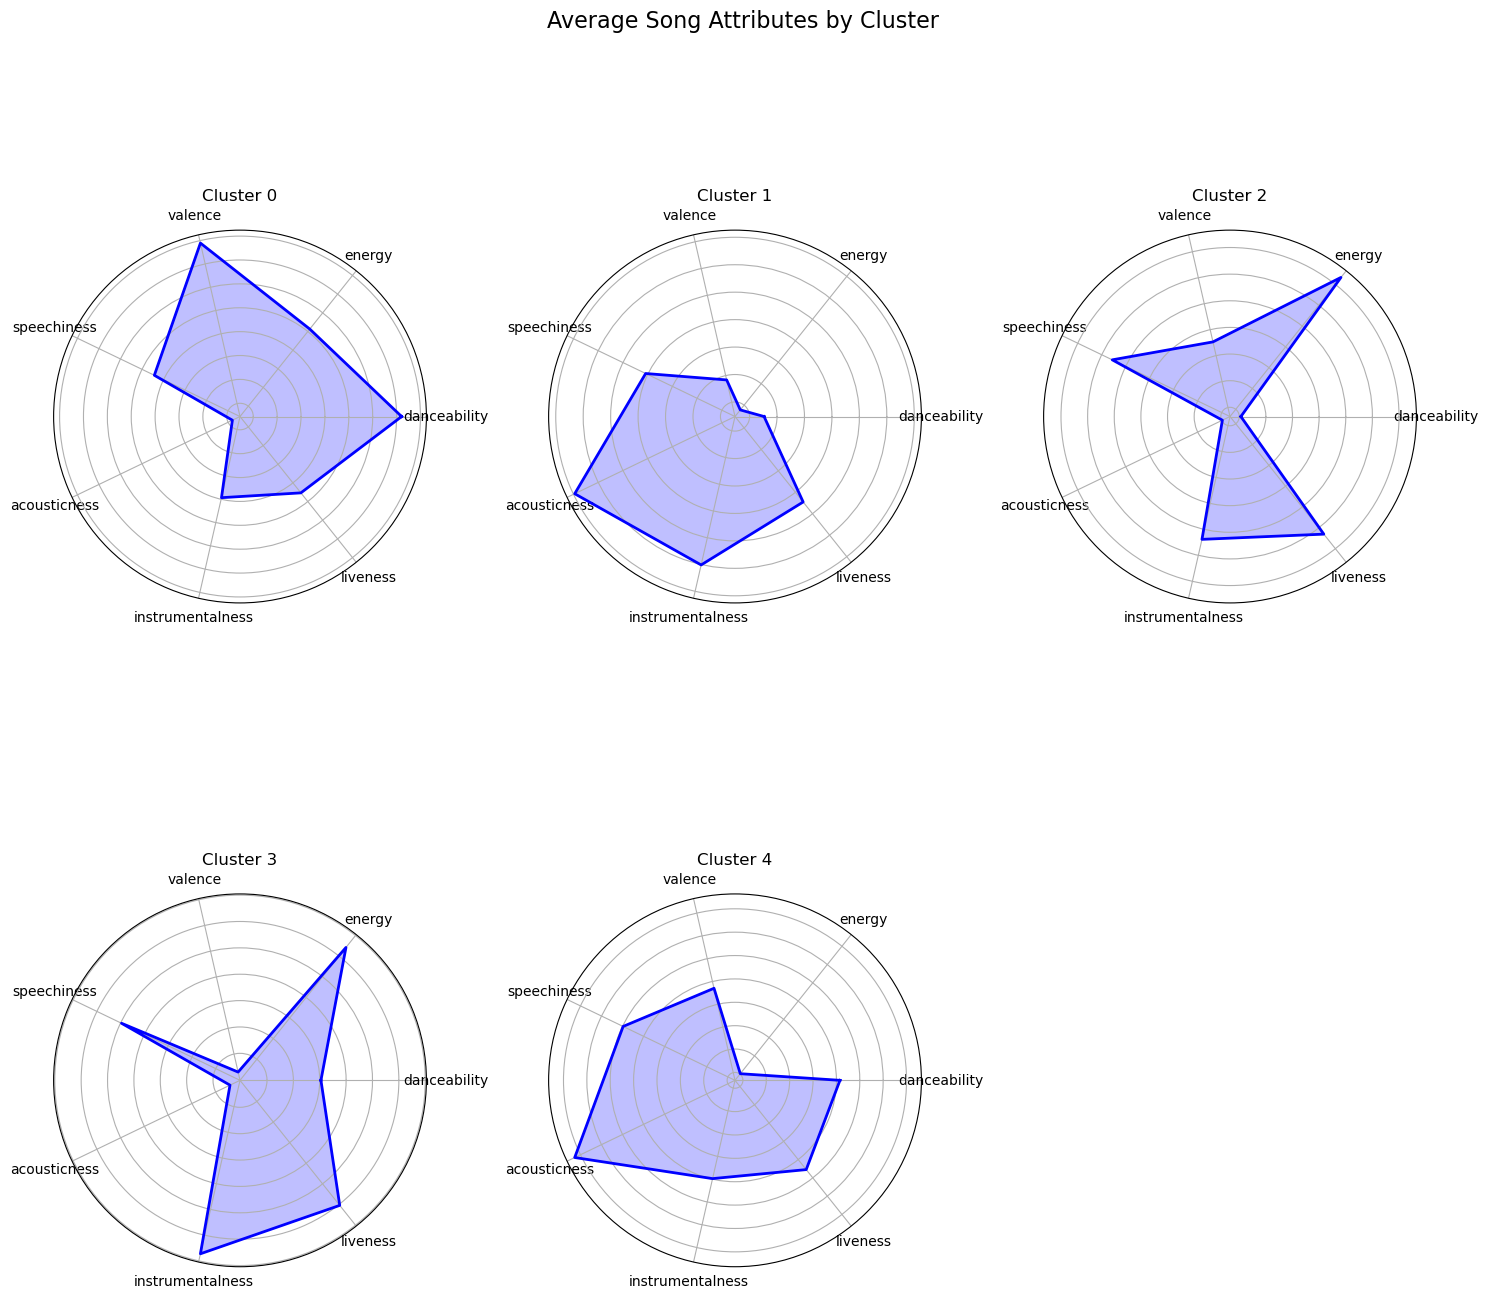

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the attributes we're interested in
attributes = ['danceability', 'energy', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']
num_vars = len(attributes)

# Compute the angle for each axis on the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Add the first angle to close the circle
angles_with_loop = angles + angles[:1]

# Number of clusters
clusters = sorted(df['cluster'].unique())
num_clusters = len(clusters)

# Create subplots grid
fig, axs = plt.subplots(
    nrows=(num_clusters + 2) // 3, ncols=3,  # Adjust grid to have 3 columns and enough rows
    figsize=(15, 15), subplot_kw=dict(polar=True)
)

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Loop through each cluster and create a radar plot
for idx, cluster in enumerate(clusters):
    # Filter data for the current cluster
    df_cluster = df[df['cluster'] == cluster]
    
    # Compute the mean of the attributes for the current cluster
    df_selected = df_cluster[attributes].mean().values
    df_selected = np.concatenate((df_selected, [df_selected[0]]))  # Complete the loop
    
    # Plot on the corresponding subplot
    ax = axs[idx]
    ax.fill(angles_with_loop, df_selected, color='blue', alpha=0.25)
    ax.plot(angles_with_loop, df_selected, color='blue', linewidth=2)
    
    # Labels for each axis
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(attributes)
    
    # Title for each cluster
    ax.set_title(f'Cluster {cluster}')

# Turn off unused subplots (if any)
for ax in axs[len(clusters):]:
    ax.axis('off')

# Add a main title
plt.suptitle('Average Song Attributes by Cluster', fontsize=16)
plt.tight_layout()
plt.show()




### **Radar Charts of Average Song Attributes by Cluster**
These radar charts provide a detailed view of the average audio features for each cluster:

#### **Cluster 0 (Upbeat Dance & Pop Hits):**
- High **danceability** and **valence** (happiness), with moderate **energy**.
- Tracks in this cluster are lively and fun, ideal for celebrations or dance settings.
  
#### **Cluster 1 (Mellow & Acoustic Relaxation):**
- Low **danceability**, **energy**, and **valence**, but high **acousticness** and **instrumentalness**.
- Tracks are calm, soothing, and acoustic—perfect for relaxation or introspective moments.

#### **Cluster 2 (High-Energy Dance & Hip-Hop):**
- High **energy** and **tempo**, with moderate **danceability** and **speechiness**.
- Tracks in this cluster are fast-paced and intense, ideal for workouts or high-energy activities.

#### **Cluster 3 (Dark & Alternative Electronica):**
- Moderate **danceability** and **energy**, with low **valence** (darker mood).
- These tracks are intense yet moody, appealing to fans of alternative or electronic music.

#### **Cluster 4 (Chilled & Acoustic Folk):**
- Moderate **acousticness** and **valence**, with low **energy** and **tempo**.
- Tracks are mellow and slightly positive, suitable for relaxed and casual settings.


In [9]:
# Updated cluster labels based on the distributions and means
cluster_labels = {
    0: 'Upbeat Dance & Party Hits - Tracks with high danceability and positivity. These are fun and lively, perfect for celebrations, parties, or uplifting moods.',
    1: 'Mellow Acoustic & Relaxing Tunes - Slow-paced tracks with low energy and high acousticness. Ideal for calm environments like meditation, study sessions, or unwinding.',
    2: 'High-Energy Workout & Fast-Paced Hits - Extremely energetic tracks with fast tempos. These are great for workouts, intense activities, or energizing playlists.',
    3: 'Dark & Moody Alternative - Tracks with moderate energy and a darker mood. Perfect for fans of alternative music, electronic beats, or introspective moments.',
    4: 'Chilled Acoustic & Folk Vibes - Mellow tracks with moderate positivity and acoustic instrumentation. Suitable for casual settings, relaxing evenings, or cozy vibes.',
}

# Map the updated labels to the clusters
df['cluster_label'] = df['cluster'].map(cluster_labels)

# Display the first few rows to verify
df[['cluster', 'cluster_label']].head()


# Save the updated DataFrame to a new CSV file
df.to_csv('clustered_data.csv', index=False)


### **Understanding the Clusters**
The clustering analysis revealed five distinct groupings of songs, each representing unique characteristics of the tracks' audio features:

1. **Cluster 0 (Upbeat Dance & Party Hits):**
   - This cluster includes tracks that are highly danceable and positive, making them perfect for high-energy settings such as parties or social gatherings.
   - The energy distribution shows moderate intensity, balancing vibrant beats with accessibility.

2. **Cluster 1 (Mellow Acoustic & Relaxing Tunes):**
   - Composed of calm and soothing tracks with high acousticness and low energy, this cluster is ideal for relaxation, study sessions, or reflective moods.
   - The tempo and energy distributions reinforce the tranquil nature of these tracks.

3. **Cluster 2 (High-Energy Workout & Fast-Paced Hits):**
   - These tracks are characterized by high energy and fast tempos, perfect for workout sessions or other physically engaging activities.
   - The energy and tempo distributions highlight their fast-paced and intense nature.

4. **Cluster 3 (Dark & Moody Alternative):**
   - Tracks in this cluster have a darker mood, with moderate energy and danceability, catering to fans of alternative or electronic music.
   - The radar chart highlights a unique combination of features, emphasizing mood over energy.

5. **Cluster 4 (Chilled Acoustic & Folk Vibes):**
   - This cluster features mellow tracks with acoustic instrumentation and moderate positivity, suitable for casual listening or relaxing settings.
   - The tempo distribution and radar chart showcase a balance between calm and slightly upbeat qualities.

#### **How the Clusters Inform Recommendations**
- The distinct characteristics of each cluster provide a foundation for building personalized recommendations.
- For example:
  - Suggest tracks from **Cluster 2** for fitness enthusiasts seeking energetic playlists.
  - Recommend **Cluster 1** tracks for users interested in meditative or acoustic music.
- The clusters can also be used to create genre-specific playlists or mood-based groupings, enhancing user engagement.



## Basic Recommendation System
This is a basic recommendation system we will build to test the framework based on the kmeans clustering.



Let's build a basic recommendation system using the k-means clustering results as the framework. Here's how we can proceed step by step:

The basic recommendation system will:

1. Recommend songs within the same cluster as the user's selected song.
2. Recommend songs from neighboring clusters (based on PCA or feature similarity).
3. Allow flexibility for a user to input preferences such as energy level, tempo, or mood (valence).

In [10]:
df_generel = pd.read_csv('generel_data.csv')
df_cluster = pd.read_csv('clustered_data.csv')

merged_data = df_cluster.merge(df_generel, on='track_id', how='left')

merged_data.to_csv('merged_data.csv', index=False)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def format_recommendations(recommendations, reason):
    """
    Format recommendations into a user-friendly view.
    
    Parameters:
    - recommendations: DataFrame of recommended songs.
    - reason: String explaining why the songs were recommended.
    
    Returns:
    A formatted string with key song details and the reason for recommendation.
    """
    formatted = []
    for _, row in recommendations.iterrows():
        details = (
            f"Track Name: {row['track_name']}\n"
            f"Artist: {row['artist']}\n"
            f"Genre: {row['track_genre']}\n"
            f"Cluster: {row['cluster_label']}\n"
            f"Reason: {reason}\n"
        )
        formatted.append(details)
    return "\n".join(formatted)


def recommend_same_cluster(track_id, df, num_recommendations=5, raw=False):
    if track_id not in df['track_id'].values:
        raise ValueError(f"Track ID '{track_id}' not found in the dataset.")
    
    cluster = df.loc[df['track_id'] == track_id, 'cluster'].values[0]
    same_cluster = df[df['cluster'] == cluster]
    recommendations = same_cluster[same_cluster['track_id'] != track_id].sample(
        n=min(num_recommendations, len(same_cluster))
    )
    
    if raw:
        return recommendations  # Return raw DataFrame for calculations
    return format_recommendations(recommendations, "From the same cluster as the selected track.")


def recommend_similar_songs(track_id, df, num_recommendations=5, features=None, raw=False):
    if features is None:
        features = ['danceability_x', 'energy_x', 'valence_x', 'tempo_x', 
                    'acousticness_x', 'speechiness_log', 'instrumentalness_log', 'liveness_log']
    if track_id not in df['track_id'].values:
        raise ValueError(f"Track ID '{track_id}' not found in the dataset.")
    
    track_features = df[df['track_id'] == track_id][features].values.reshape(1, -1)
    similarity_scores = cosine_similarity(track_features, df[features])[0]
    df['similarity'] = similarity_scores
    
    recommendations = df[df['track_id'] != track_id].sort_values(by='similarity', ascending=False).head(num_recommendations)
    
    if raw:
        return recommendations  # Return raw DataFrame for calculations
    return format_recommendations(recommendations, "Based on similar features to the selected track.")


def recommend_from_neighbors(track_id, df, num_recommendations=5, raw=False):
    if track_id not in df['track_id'].values:
        raise ValueError(f"Track ID '{track_id}' not found in the dataset.")
    
    cluster = df.loc[df['track_id'] == track_id, 'cluster'].values[0]
    pca_cluster_centers = df.groupby('cluster')[['pca1', 'pca2']].mean()
    selected_cluster_pca = pca_cluster_centers.loc[cluster].values.reshape(1, -1)
    distances = cosine_similarity(selected_cluster_pca, pca_cluster_centers)[0]
    similar_clusters = pca_cluster_centers.index[np.argsort(-distances)]
    
    recommendations = []
    for similar_cluster in similar_clusters:
        if similar_cluster == cluster:
            continue
        similar_cluster_tracks = df[df['cluster'] == similar_cluster]
        recommendations.append(similar_cluster_tracks)
        if len(pd.concat(recommendations)) >= num_recommendations:
            break
    
    if recommendations:
        recommendations_df = pd.concat(recommendations).sample(n=min(num_recommendations, len(pd.concat(recommendations))))
        if raw:
            return recommendations_df  # Return raw DataFrame for calculations
        return format_recommendations(recommendations_df, "From clusters neighboring the selected track's cluster.")
    
    return "No recommendations found in neighboring clusters."




# Example song for recommendation (A valid track_id from dataset)
track_id = '1iJBSr7s7jYXzM8EGcbK5b'

# 1. Recommend songs within the same cluster
print("Recommendations from the same cluster:")
print(recommend_same_cluster(track_id, merged_data))

# 2. Recommend similar songs within the same cluster
print("Recommendations based on similar features:")
print(recommend_similar_songs(track_id, merged_data))

# 3. Recommend songs from neighboring clusters
print("Recommendations from neighboring clusters:")
print(recommend_from_neighbors(track_id, merged_data))




Recommendations from the same cluster:
Track Name: Make It To Christmas
Artist: Alessia Cara
Genre: electro
Cluster: Dark & Moody Alternative - Tracks with moderate energy and a darker mood. Perfect for fans of alternative music, electronic beats, or introspective moments.
Reason: From the same cluster as the selected track.

Track Name: Are You Dead Yet?
Artist: Children Of Bodom
Genre: death-metal
Cluster: Dark & Moody Alternative - Tracks with moderate energy and a darker mood. Perfect for fans of alternative music, electronic beats, or introspective moments.
Reason: From the same cluster as the selected track.

Track Name: Don't Let the Sun Go Down on Me
Artist: Me First and the Gimme Gimmes
Genre: ska
Cluster: Dark & Moody Alternative - Tracks with moderate energy and a darker mood. Perfect for fans of alternative music, electronic beats, or introspective moments.
Reason: From the same cluster as the selected track.

Track Name: Come on Home
Artist: Everything But The Girl
Genre: 

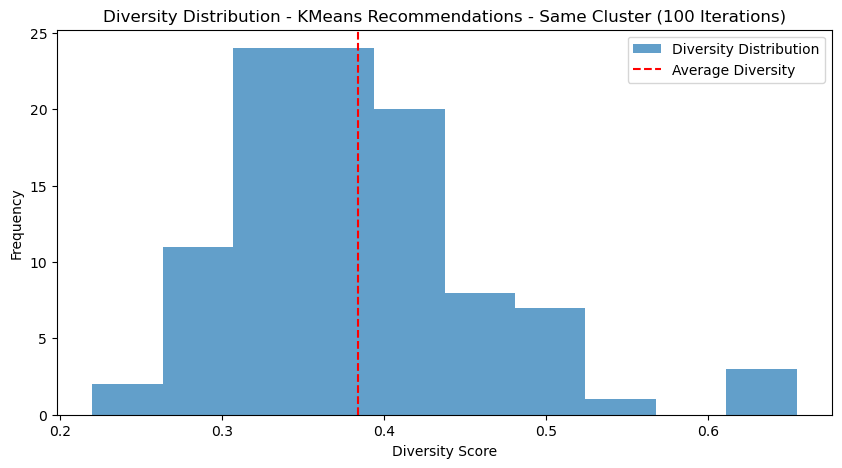

In [12]:
import matplotlib.pyplot as plt

def calculate_diversity(recommendations, feature_columns):
    """
    Calculate feature variance for diversity.
    """
    # Ensure recommendations is a DataFrame
    feature_variance = recommendations[feature_columns].var().mean()
    return feature_variance

def calculate_average_diversity_with_iterations(song_ids, merged_data, feature_columns, recommendation_function, iterations=10):
    """
    Calculate the average diversity of recommendations for a list of songs over multiple iterations.
    
    Parameters:
        song_ids (list): List of track IDs to generate recommendations for.
        merged_data (DataFrame): The full dataset containing song features.
        feature_columns (list): Columns to calculate diversity.
        recommendation_function (function): Function to generate recommendations for a given song.
        iterations (int): Number of iterations to compute the average diversity.
        
    Returns:
        list: Average diversities for each iteration.
    """
    average_diversities = []
    
    for _ in range(iterations):
        diversities = []
        
        for track_id in song_ids:
            # Get recommendations using the provided recommendation function
            recommendations = recommendation_function(track_id, merged_data, raw=True)
            
            # Calculate diversity for the recommendations
            diversity = calculate_diversity(recommendations, feature_columns)
            diversities.append(diversity)
        
        # Calculate the average diversity for this iteration
        average_diversity = sum(diversities) / len(diversities)
        average_diversities.append(average_diversity)
    
    return average_diversities

# Example song IDs for diversity calculation
song_ids = ['1EzrEOXmMH3G43AXT1y7pA', '6Vc5wAMmXdKIAM7WUoEb7N', '0BUuuEvNa5T4lMaewyiudB']  
feature_columns = ['danceability_x', 'valence_x', 'tempo_x', 'energy_x', 'acousticness_x', 'speechiness_log', 'instrumentalness_log', 'liveness_log']  

# Perform diversity calculations over multiple iterations
diversities_over_iterations_kmeans = calculate_average_diversity_with_iterations(
    song_ids,
    merged_data,
    feature_columns,
    recommend_same_cluster,  # Pass the KMeans-based recommendation function
    iterations=100
)

# Plot the results
plt.figure(figsize=(10, 5))

# Histogram of diversities
plt.hist(diversities_over_iterations_kmeans, bins=10, alpha=0.7, label="Diversity Distribution")
plt.axvline(x=sum(diversities_over_iterations_kmeans) / len(diversities_over_iterations_kmeans), color="red", linestyle="--", label="Average Diversity")
plt.title("Diversity Distribution - KMeans Recommendations - Same Cluster (100 Iterations)")
plt.xlabel("Diversity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


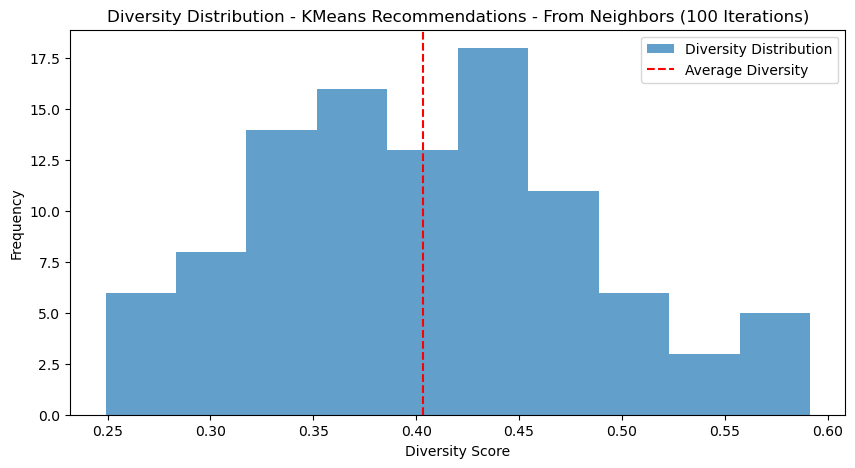

In [13]:

# Perform diversity calculations over multiple iterations
diversities_over_iterations_kmeans = calculate_average_diversity_with_iterations(
    song_ids,
    merged_data,
    feature_columns,
    recommend_from_neighbors,  # Pass the KMeans-based recommendation function
    iterations=100
)

# Plot the results
plt.figure(figsize=(10, 5))

# Histogram of diversities
plt.hist(diversities_over_iterations_kmeans, bins=10, alpha=0.7, label="Diversity Distribution")
plt.axvline(x=sum(diversities_over_iterations_kmeans) / len(diversities_over_iterations_kmeans), color="red", linestyle="--", label="Average Diversity")
plt.title("Diversity Distribution - KMeans Recommendations - From Neighbors (100 Iterations)")
plt.xlabel("Diversity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()